# ENVIRONMENT & LIBRARY SETUP

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.optimize import minimize
from datetime import datetime
from fredapi import Fred

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get the API key from the environment
api_key = os.getenv('API_KEY')

# Use the API key to initialize Fred
fred = Fred(api_key=api_key)

#  STEP 1: DATA COLLECTION FROM FRED

              1Y    2Y    3Y    5Y    7Y   10Y   30Y
2015-01-02  0.25  0.66  1.07  1.61  1.92  2.12  2.69
2015-01-05  0.26  0.68  1.06  1.57  1.85  2.04  2.60
2015-01-06  0.25  0.65  1.02  1.50  1.78  1.97  2.52
2015-01-07  0.25  0.62  1.00  1.47  1.76  1.96  2.52
2015-01-08  0.23  0.62  1.00  1.50  1.81  2.03  2.59


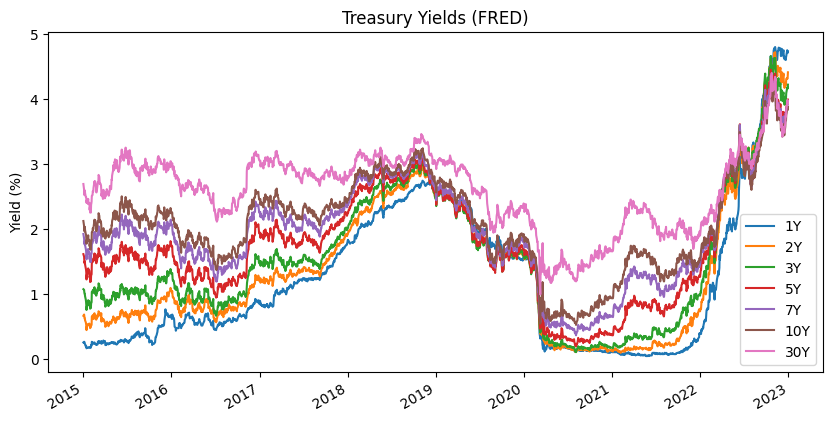

In [2]:

# Example series IDs (daily treasury yields):
# 1-year: "DGS1", 2-year: "DGS2", 3-year: "DGS3", 5-year: "DGS5", 7-year: "DGS7", 10-year: "DGS10", 30-year: "DGS30"
maturities = ["DGS1", "DGS2", "DGS3", "DGS5", "DGS7", "DGS10", "DGS30"]
labels = ["1Y", "2Y", "3Y", "5Y", "7Y", "10Y", "30Y"]

start_date = "2015-01-01"
end_date = "2023-01-01"

dfs = {}
for mat in maturities:
    data = fred.get_series(mat, observation_start=start_date, observation_end=end_date)
    df_temp = pd.DataFrame(data, columns=[mat])
    dfs[mat] = df_temp

# Combine into single DataFrame
df_yields = pd.concat(dfs.values(), axis=1)
df_yields.sort_index(inplace=True)
df_yields.dropna(inplace=True)
df_yields.columns = labels  # rename columns e.g. [1Y, 2Y, 3Y, ...]
print(df_yields.head())

# Plot yields
df_yields.plot(figsize=(10,5))
plt.title("Treasury Yields (FRED)")
plt.ylabel("Yield (%)")
plt.show()


# 2) PCA ON YIELD CHANGES

In [3]:
df_changes = df_yields.diff().dropna()

# Run PCA on yield changes
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(df_changes.values)

print("Explained Variance Ratios:", pca.explained_variance_ratio_)

# principal components
factors = pca.transform(df_changes.values)  # shape: (T, 3)
df_factors = pd.DataFrame(factors, index=df_changes.index, columns=["PC1", "PC2", "PC3"])


Explained Variance Ratios: [0.85638569 0.0946535  0.02721381]


############################################################
# 3) MODEL EACH FACTOR WITH A SIMPLE OU / AR(1) APPROACH
############################################################
# We'll do a discrete AR(1) ~ OU approximation:
#   factor_{t+1} = alpha * factor_t + noise
#   or factor_{t+1} - factor_t = -kappa * factor_t + ...
# For simplicity, let's just do AR(1) with mean ~ 0

In [6]:


import statsmodels.api as sm

def fit_ar1_series(series):
    """
    Fit AR(1): x_{t+1} = c + phi * x_t + e_t
    Return (c, phi, sigma) for the residual e_t.
    """
    y = series[1:].values
    x = sm.add_constant(series[:-1].values)  # [const, x_{t-1}]
    model = sm.OLS(y, x).fit()
    c = model.params[0]
    phi = model.params[1]
    
    residuals = y - model.predict(x)
    sigma = np.std(residuals, ddof=1)
    
    return c, phi, sigma

ar_params = {}
for col in df_factors.columns:
    c, phi, sigma = fit_ar1_series(df_factors[col])
    ar_params[col] = (c, phi, sigma)
    print(f"Factor {col}: c={c:.4f}, phi={phi:.4f}, sigma={sigma:.4f}")


Factor PC1: c=0.0001, phi=-0.0072, sigma=0.1134
Factor PC2: c=0.0000, phi=0.0572, sigma=0.0376
Factor PC3: c=0.0000, phi=-0.0002, sigma=0.0202


#  STEP 4: MONTE CARLO SIMULATION

In [9]:
############################################################
# 4) SIMULATE FACTORS
############################################################
import numpy as np

def simulate_factor_ar1(c, phi, sigma, x0, steps=252, n_sims=1000):
    """
    x_{t+1} = c + phi*x_t + sigma*Z_t
    """
    paths = np.zeros((steps+1, n_sims))
    paths[0,:] = x0
    
    for t in range(steps):
        z = np.random.normal(size=n_sims)
        paths[t+1,:] = c + phi * paths[t,:] + sigma * z
    return paths

T_sim = 252  # 1 year of daily steps
n_sims = 2000

# We'll store simulated factor paths in a dict
sim_factor_paths = {}

# x0 is last known factor value
last_factors = df_factors.iloc[-1]

for col in df_factors.columns:
    c, phi, sigma = ar_params[col]
    x0 = last_factors[col]
    paths = simulate_factor_ar1(c, phi, sigma, x0, steps=T_sim, n_sims=n_sims)
    sim_factor_paths[col] = paths


#  STEP 5: ZERO-COUPON BOND PRICING VIA MONTE CARLO

PCA Loadings shape: (3, 7)


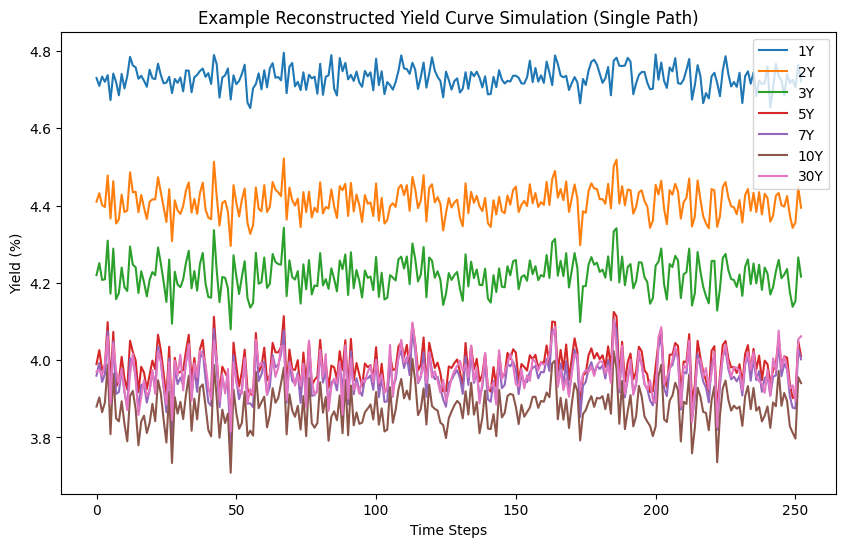

In [10]:
############################################################
# 5) RECONSTRUCT YIELD CURVE FROM FACTORS
############################################################

# Recall that we have pca.components_ which are eigenvectors in yield-change space.
# We'll do a rough reconstruction approach:
#   delta_yields = factor_1 * PC1 + factor_2 * PC2 + factor_3 * PC3
# In practice, you'd pick a reference yield curve, then apply these factor changes cumulatively.

pca_loadings = pca.components_  # shape: (3, #maturities)
print("PCA Loadings shape:", pca_loadings.shape)

# We'll define a reference yield curve as the last known yields from df_yields
ref_curve = df_yields.iloc[-1].values  # shape: (#maturities,)

def reconstruct_yields_from_factors(factor_array, ref_curve, pca_loads):
    """
    factor_array: shape (steps+1) x 3   (for 3 factors)
    ref_curve: shape (#maturities,) base yield level
    pca_loads: shape (3, #maturities)
    returns: yields_array shape (steps+1, #maturities)
    """
    steps_plus_1 = factor_array.shape[0]
    n_mat = ref_curve.shape[0]
    yields_out = np.zeros((steps_plus_1, n_mat))
    
    yields_out[0,:] = ref_curve  # start from reference
    for t in range(1, steps_plus_1):
        dfacs = factor_array[t,:]  # current factor values
        # interpret dfacs as "change" from 0
        # We'll do a simple linear combination:
        delta_y = dfacs @ pca_loads  # shape (#maturities,)
        yields_out[t,:] = ref_curve + delta_y
    return yields_out

# We'll pick one sample path from each factor sim to show an example reconstruction
import random

sample_idx = random.randint(0, n_sims-1)
factor_paths_3 = np.zeros((T_sim+1, 3))  # combine the 3 factor paths into one array
for i, col in enumerate(["PC1","PC2","PC3"]):
    factor_paths_3[:, i] = sim_factor_paths[col][:, sample_idx]

# Reconstruct yields
yield_sims_example = reconstruct_yields_from_factors(factor_paths_3, ref_curve, pca_loadings)

# Plot yields for each maturity
plt.figure(figsize=(10,6))
for i, lbl in enumerate(labels):
    plt.plot(yield_sims_example[:, i], label=lbl)
plt.title("Example Reconstructed Yield Curve Simulation (Single Path)")
plt.ylabel("Yield (%)")
plt.xlabel("Time Steps")
plt.legend()
plt.show()


Transition matrix:
 [[0.08305599 0.91694401]
 [0.88094372 0.11905628]]
Means:
 [[1.22126412]
 [1.22152919]]
Covars:
 [[[1.25335075]]

 [[1.25369353]]]


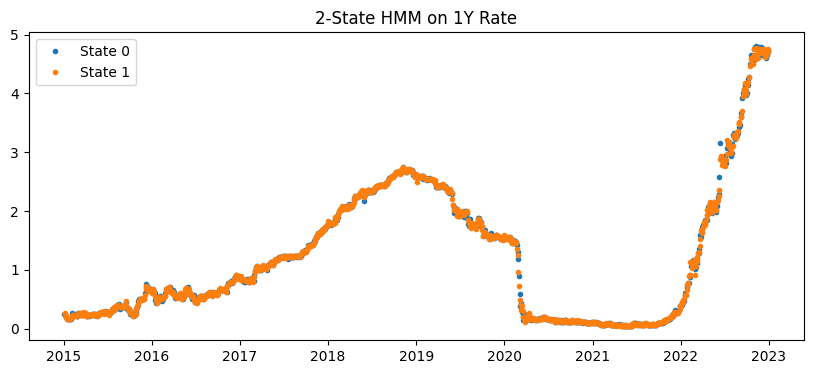

In [11]:
###########################################################
# EXAMPLE: 2-State HMM on Short Rate
#   We'll train the HMM on the same short_rate series
#   to detect low-rate vs. high-rate regimes.
###########################################################
!pip install hmmlearn
from hmmlearn.hmm import GaussianHMM

# Suppose we have the short rate series in df_yields['1Y'] or a single column
sr_data = df_yields['1Y'].dropna().values.reshape(-1,1)

# Fit a 2-state Gaussian HMM to the short rate levels
hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=200)
hmm_model.fit(sr_data)

# The model now has means_ and covars_ for each hidden state
print("Transition matrix:\n", hmm_model.transmat_)
print("Means:\n", hmm_model.means_)
print("Covars:\n", hmm_model.covars_)

# We can predict the hidden state for each time step
hidden_states = hmm_model.predict(sr_data)
df_hmm = pd.DataFrame({
    'Rate': sr_data.flatten(),
    'State': hidden_states
}, index=df_yields['1Y'].dropna().index)

# Plot states
plt.figure(figsize=(10,4))
for state in range(hmm_model.n_components):
    state_mask = (df_hmm['State'] == state)
    plt.plot(df_hmm.index[state_mask], df_hmm['Rate'][state_mask], '.', label=f"State {state}")
plt.title("2-State HMM on 1Y Rate")
plt.legend()
plt.show()


In [12]:
def simulate_hmm_short_rate(hmm_model, start_state=None, steps=252, n_sims=1000):
    """
    For each path, we sample state transitions from the hmm_model's transition matrix,
    then sample the short rate from the state's Gaussian distribution.
    """
    n_states = hmm_model.n_components
    trans_mat = hmm_model.transmat_
    means = hmm_model.means_.flatten()   # shape: (n_states,)
    covars = hmm_model.covars_.flatten() # shape: (n_states,)

    paths = np.zeros((steps, n_sims))
    
    # If start_state is None, choose randomly based on initial state distribution
    if start_state is None:
        start_probs = hmm_model.startprob_
    else:
        start_probs = np.zeros(n_states)
        start_probs[start_state] = 1.0
    
    for sim in range(n_sims):
        # initial state
        s = np.random.choice(n_states, p=start_probs)
        for t in range(steps):
            # sample rate from state's Gaussian
            rate_t = np.random.normal(means[s], np.sqrt(covars[s]))
            paths[t, sim] = rate_t
            
            # move to next state
            s = np.random.choice(n_states, p=trans_mat[s])
    return paths

hmm_paths = simulate_hmm_short_rate(hmm_model, steps=252, n_sims=2000)
